# Load data

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory
image_size = (256, 256)
train_ds, val_ds = image_dataset_from_directory(
    "/kaggle/input/real-and-fake-face-detection/real_and_fake_face",
    validation_split=0.2,
    subset="both",
    label_mode = "categorical",
    seed=123,
    batch_size = 32,
    image_size=image_size)

Found 2041 files belonging to 2 classes.
Using 1633 files for training.
Using 408 files for validation.


# CNN base model

In [6]:
from tensorflow.keras.metrics import Recall, Precision

metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

In [7]:
from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy

model = models.Sequential()

model.add(layers.Rescaling(1/255, input_shape=(image_size[0],image_size[1],3)))
model.add(layers.Conv2D(8, kernel_size = (4,4), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(16, kernel_size = (3,3), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(32, kernel_size = (2,2), activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(rate=0.2))  
model.add(layers.Dense(2, activation='softmax'))

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=metrics)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(patience = 5, 
                   restore_best_weights = True,
                   monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('base_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

history = model.fit(train_ds,
          validation_data = val_ds,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])


Epoch 1/20
52/52 [==============================] - 20s 243ms/step - loss: 0.7073 - recall: 0.5028 - precision: 0.5028 - accuracy: 0.5028 - val_loss: 0.6964 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 2/20
52/52 [==============================] - 17s 291ms/step - loss: 0.6927 - recall: 0.5144 - precision: 0.5144 - accuracy: 0.5144 - val_loss: 0.6923 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 3/20
52/52 [==============================] - 14s 245ms/step - loss: 0.6897 - recall: 0.5230 - precision: 0.5230 - accuracy: 0.5230 - val_loss: 0.6941 - val_recall: 0.5147 - val_precision: 0.5147 - val_accuracy: 0.5147
Epoch 4/20
52/52 [==============================] - 14s 240ms/step - loss: 0.6902 - recall: 0.5334 - precision: 0.5334 - accuracy: 0.5334 - val_loss: 0.6868 - val_recall: 0.5172 - val_precision: 0.5172 - val_accuracy: 0.5172
Epoch 5/20
52/52 [==============================] - 13s 223ms/step - loss: 0.6824 - recall: 0.5573 -

In [9]:
import matplotlib.pyplot as plt
def plot_loss_precision_recall_curve(history):
    
    fig, ax =plt.subplots(1,3,figsize=(20,5))
    
    # --- LOSS
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'], loc='upper right')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- RECALL
    ax[1].plot(history.history['recall'])
    ax[1].plot(history.history['val_recall'])
    ax[1].set_title('Model recall', fontsize = 18)
    ax[1].set_xlabel('Epoch', fontsize = 14)
    ax[1].set_ylabel('Recall', fontsize = 14)
    ax[1].legend(['Train', 'Val'], loc='lower right') 
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    # --- PRECISION
    
    
    ax[2].plot(history.history['precision'])
    ax[2].plot(history.history['val_precision'])
    ax[2].set_title('Model precision', fontsize = 18)
    ax[2].set_xlabel('Epoch', fontsize = 14)
    ax[2].set_ylabel('Precision', fontsize = 14)
    ax[2].legend(['Train', 'Val'], loc='lower right')  
    ax[2].grid(axis="x",linewidth=0.5)
    ax[2].grid(axis="y",linewidth=0.5)    
    
    plt.show()


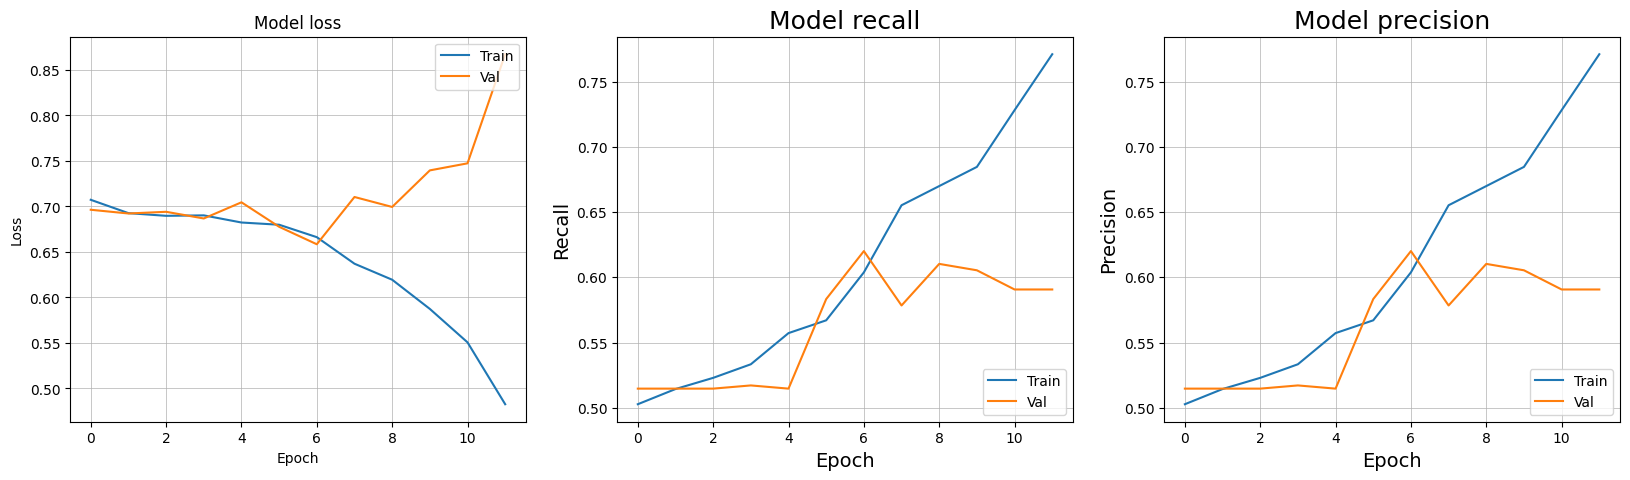

In [10]:
plot_loss_precision_recall_curve(history)

In [ ]:
model.evaluate(val_ds)

#  CNN transfer learning

## VGG16(trained on ImageNet)

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG16 = VGG16(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
VGG16.trainable = False
VGG16 = Sequential([
    VGG16,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])
from tensorflow.keras.applications.vgg16 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

In [16]:
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
es = EarlyStopping(patience = 5, 
                   restore_best_weights = True,
                   monitor = 'val_loss')

mcp = ModelCheckpoint("{}.h5".format('VGG_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)
metrics = [
    Recall(name='recall'),
    Precision(name='precision'),
    'accuracy']

VGG16.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=metrics)
hist_vgg16 = VGG16.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])

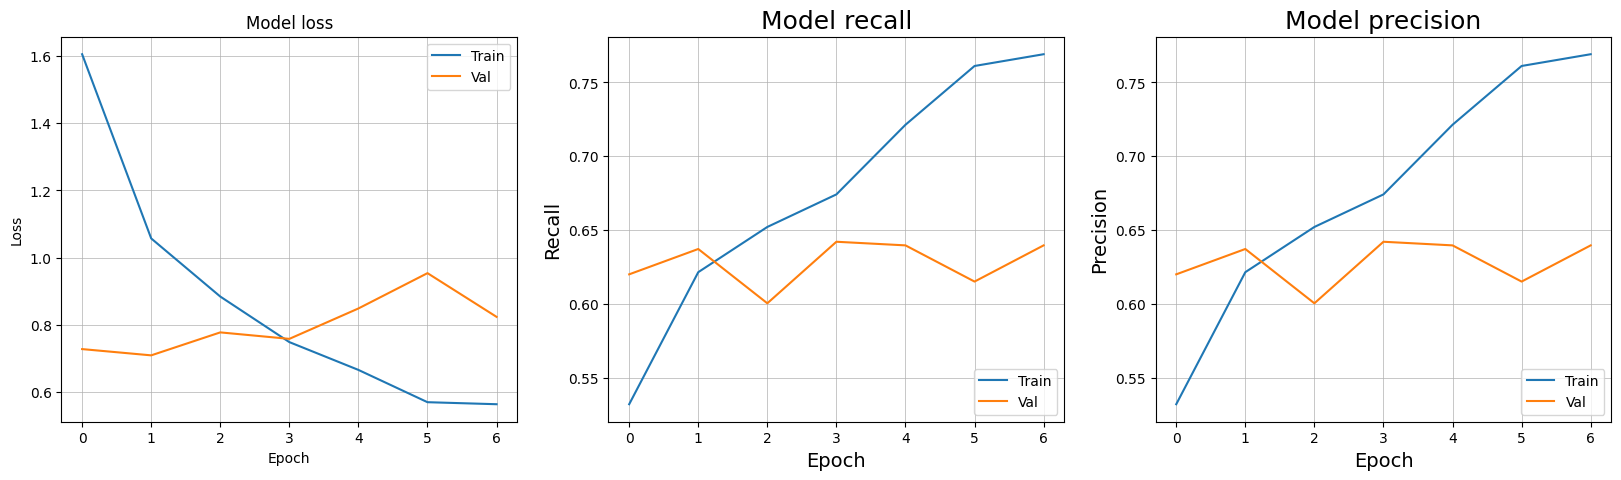

In [18]:
plot_loss_precision_recall_curve(hist_vgg16)

## InceptionV3

In [24]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
InceptionV3 = InceptionV3(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

InceptionV3.trainable = False
InceptionV3 = Sequential([
    InceptionV3,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])

from tensorflow.keras.applications.inception_v3 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

In [25]:
mcp = ModelCheckpoint("{}.h5".format('InceptiveV3_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

from tensorflow.keras.optimizers import Adam
InceptionV3.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=metrics)

hist_InceptionV3 = InceptionV3.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])

Epoch 1/20
52/52 [==============================] - 26s 337ms/step - loss: 1.3602 - recall: 0.5321 - precision: 0.5321 - accuracy: 0.5132 - val_loss: 0.6941 - val_recall: 0.5270 - val_precision: 0.5270 - val_accuracy: 0.5270
Epoch 2/20
52/52 [==============================] - 16s 275ms/step - loss: 0.6928 - recall: 0.5542 - precision: 0.5542 - accuracy: 0.5542 - val_loss: 0.6793 - val_recall: 0.5686 - val_precision: 0.5686 - val_accuracy: 0.5686
Epoch 3/20
52/52 [==============================] - 17s 295ms/step - loss: 0.6748 - recall: 0.5499 - precision: 0.5499 - accuracy: 0.5499 - val_loss: 0.6824 - val_recall: 0.5172 - val_precision: 0.5172 - val_accuracy: 0.5172
Epoch 4/20
52/52 [==============================] - 17s 305ms/step - loss: 0.6485 - recall: 0.5738 - precision: 0.5738 - accuracy: 0.5738 - val_loss: 0.6868 - val_recall: 0.5662 - val_precision: 0.5662 - val_accuracy: 0.5662
Epoch 5/20
52/52 [==============================] - 17s 308ms/step - loss: 0.6233 - recall: 0.6234 -

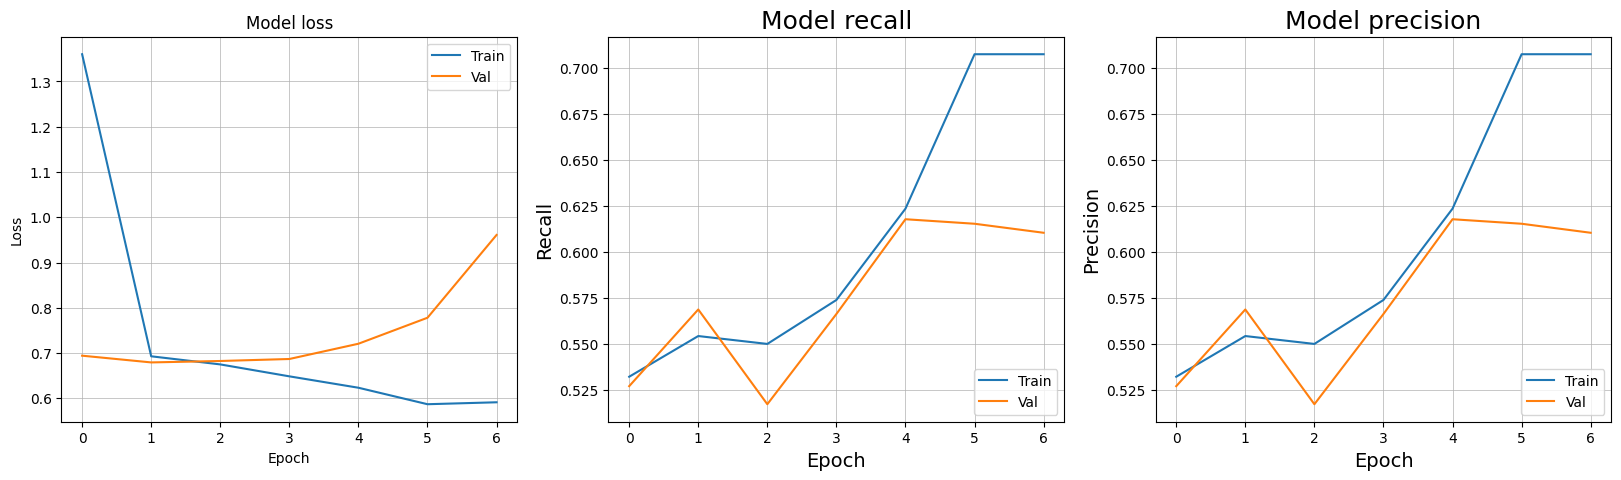

In [26]:
plot_loss_precision_recall_curve(hist_InceptionV3)

## ResNet50

In [27]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet50 = ResNet50(
    weights='imagenet',
    input_shape=(image_size[0],image_size[1], 3),
    include_top=False)

from tensorflow.keras import models, Sequential, layers, regularizers
from tensorflow.keras.losses import CategoricalCrossentropy
ResNet50.trainable = False
ResNet50 = Sequential([
    ResNet50,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate=0.2),
    layers.Dense(2, activation='softmax')
])
from tensorflow.keras.applications.resnet50 import preprocess_input
train_ds_preprocessed= train_ds.map(lambda X, y: (preprocess_input(X), y))
val_ds_preprocessed= val_ds.map(lambda X, y: (preprocess_input(X), y))

94765736/94765736 [==============================] - 1s 0us/step


In [29]:
mcp = ModelCheckpoint("{}.h5".format('ResNet50_model'),
                      save_weights_only=True,
                      monitor='val_loss',
                      mode='min',
                      verbose=0,
                      save_best_only=True)

from tensorflow.keras.optimizers import Adam
ResNet50.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=metrics)

hist_ResNet50 = ResNet50.fit(train_ds_preprocessed,
          validation_data = val_ds_preprocessed,
          batch_size = 32,
          epochs = 20,
          callbacks = [es,mcp])

Epoch 1/20
52/52 [==============================] - 30s 415ms/step - loss: 0.8827 - recall: 0.5434 - precision: 0.5434 - accuracy: 0.5266 - val_loss: 0.6682 - val_recall: 0.6078 - val_precision: 0.6078 - val_accuracy: 0.6078
Epoch 2/20
52/52 [==============================] - 21s 374ms/step - loss: 0.6669 - recall: 0.6338 - precision: 0.6338 - accuracy: 0.6338 - val_loss: 0.6360 - val_recall: 0.6275 - val_precision: 0.6275 - val_accuracy: 0.6275
Epoch 3/20
52/52 [==============================] - 21s 377ms/step - loss: 0.5922 - recall: 0.7055 - precision: 0.7055 - accuracy: 0.7055 - val_loss: 0.6552 - val_recall: 0.6324 - val_precision: 0.6324 - val_accuracy: 0.6324
Epoch 4/20
52/52 [==============================] - 20s 359ms/step - loss: 0.5360 - recall: 0.7630 - precision: 0.7630 - accuracy: 0.7630 - val_loss: 0.6435 - val_recall: 0.6520 - val_precision: 0.6520 - val_accuracy: 0.6520
Epoch 5/20
52/52 [==============================] - 21s 365ms/step - loss: 0.4208 - recall: 0.8242 -

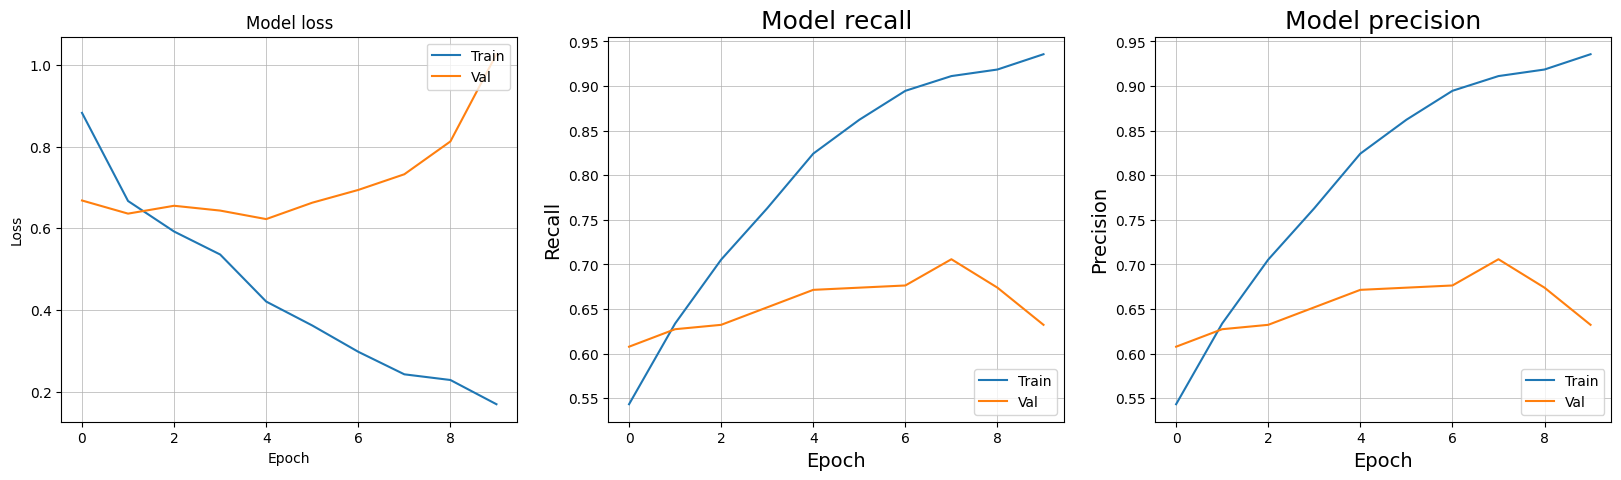

In [30]:
plot_loss_precision_recall_curve(hist_ResNet50)